In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from scipy.io import loadmat
import os
import scipy.io as sio
import numpy.linalg as la
from tqdm import tqdm

from koopman_pseudospec_qr import KoopPseudoSpecQR
from matplotlib.colors import ListedColormap, BoundaryNorm
# Load the specified MAT-file using scipy.io.loadmat()
file_path = 'data/pendulum_data/data_pendulum_90.mat'
# file_path = 'data_pendulum_90.mat'
data_pendulum = loadmat(file_path)


In [2]:
print (torch.__version__, torch.cuda.is_available())
device= 'cuda'
#device= 'cpu'
torch.set_default_dtype(torch.float64)

# torch.cuda.get_device_name()

2.3.1 True


In [3]:
# Assuming the loaded MAT-file is named data_pendulum_90
X = data_pendulum['DATA_X']
Y = data_pendulum['DATA_Y']

print(X.shape)

(90000, 2)


In [4]:
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

In [5]:
checkpoint_file= 'koopman_example_ckpt002.torch'

In [7]:
from solver_resdmd_torch import KoopmanNNTorch, KoopmanSolverTorch

dic_size = 100

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[400,400,400], n_psi_train=dic_size-3).to(device)

solver = KoopmanSolverTorch(dic=basis_function,
                         target_dim=np.shape(data_x_train)[-1],
                         reg=0.1, checkpoint_file= checkpoint_file)

torch.cuda.get_device_name()

solver.build(data_train=data_train,
             data_valid=data_valid,
             epochs=16,
             batch_size=256,
             lr=1e-5,
             log_interval=10,
             lr_decay_factor=.8)

Outer Epoch 1/16
Epoch: 1 	Training Loss: 0.460404 val loss: 0.357221
saving, val loss enhanced: 0.35722087645085077 10000
Epoch: 2 	Training Loss: 0.327749 val loss: 0.251513
saving, val loss enhanced: 0.25151288576592556 0.35722087645085077
Epoch: 3 	Training Loss: 0.224725 val loss: 0.167351
saving, val loss enhanced: 0.16735141193104347 0.25151288576592556
Epoch: 4 	Training Loss: 0.145196 val loss: 0.105519
saving, val loss enhanced: 0.10551901056581786 0.16735141193104347
Epoch 1 time: 27.84 seconds
Outer Epoch 2/16
Epoch: 1 	Training Loss: 0.433519 val loss: 0.323627
Epoch: 2 	Training Loss: 0.296448 val loss: 0.230124
Epoch: 3 	Training Loss: 0.210545 val loss: 0.162259
Epoch: 4 	Training Loss: 0.145582 val loss: 0.110020
Epoch 2 time: 20.95 seconds
Outer Epoch 3/16
Epoch: 1 	Training Loss: 0.428165 val loss: 0.316440
Epoch: 2 	Training Loss: 0.287984 val loss: 0.221917
Epoch: 3 	Training Loss: 0.201280 val loss: 0.153439
Epoch: 4 	Training Loss: 0.135882 val loss: 0.101197
sav

In [8]:
# Results from solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X().detach().cpu().numpy()
Psi_Y = solver.get_Psi_Y().detach().cpu().numpy()
Koopman_matrix_K = solver.K.detach().cpu().numpy()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y
}

In [ ]:
# # Assuming evalues is a numpy array of complex numbers
# real_parts = evalues.real
# imag_parts = evalues.imag

# # Create the plot
# plt.figure(figsize=(8, 6))
# plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# # Draw a unit circle for reference
# theta = np.linspace(0, 2*np.pi, 100)
# plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

# plt.title('Eigenvalues in Unit Circle')
# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.legend()
# plt.show()

In [ ]:
# # Define the folder path
# folder_path = 'data/pendulum_data'
# # Create the folder if it doesn't exist
# os.makedirs(folder_path, exist_ok=True)

# # Save the outputs to a .mat file named according to the number of basis functions, inside the specified folder
# file_path = os.path.join(folder_path, f'pendulum_90_resdmd_{N_dict}basis.mat')
# sio.savemat(file_path, outputs)
# print(f'Saved outputs for n_psi_train={N_dict} to {file_path}')

In [ ]:
## You can also use existing documents to plot
file_path = 'pendulum_90_resdmd_300basis.mat'

data_pendulum = loadmat(file_path)

Psi_X = data_pendulum['Psi_X']
Psi_Y = data_pendulum['Psi_Y']
dic_size = data_pendulum['N_dict'][0]
print(dic_size)

62999
(100, 100)
cond(G) is: 4.688331073254638e+16
(61,)


100%|██████████| 3721/3721 [00:13<00:00, 269.19it/s]


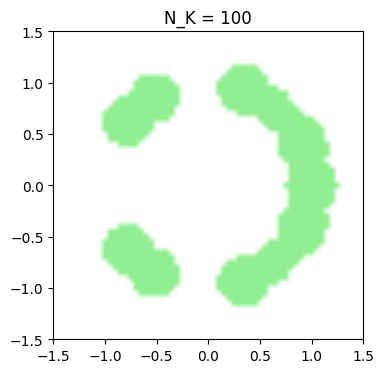

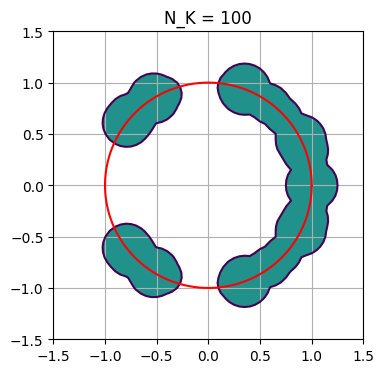

In [13]:
## Plot the pseudospectrum
m= Psi_X.shape[0]
print (m)
W = np.ones((m, 1), dtype= np.double)
G= np.dot(Psi_X.T , Psi_X)
print (G.shape)
print ('cond(G) is:',la.cond(G))
x_pts= arange (-1.5, 1.5+0.05, 0.05)
y_pts=x_pts
print (x_pts.shape)
#z_pts=kron(x_pts,ones((len(y_pts),1))+1j*kron(ones((1,len(x_pts))),y_pts))  #  z_pts=z_pts(:);
x_pts_mesh,y_pts_mesh= meshgrid (x_pts, y_pts)
z_pts= x_pts_mesh + 1j*y_pts_mesh
z_pts= z_pts.ravel()
RES= KoopPseudoSpecQR(Psi_X,Psi_Y,W,z_pts)
RES= RES.reshape (x_pts_mesh.shape)

lower_bound = 1e-16#; % Example lower bound
#Find indices where the real part of RES is zero
zero_real_indices =nonzero (np.real(RES)==0)
#% Replace only the real part of RES elements that are zero with the lower bound
RES[zero_real_indices] = lower_bound + imag(RES[zero_real_indices]) * 1j




## Plot images
# Set the threshold
threshold = 0.25
# Create a custom colormap
colors = ['lightgreen', 'white']
cmap = ListedColormap(colors)
# Define the boundaries for the colormap
boundaries = [np.min(np.real(RES)), threshold, np.max(np.real(RES))]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
# Plot 1st type of image
plt.figure(figsize=(4, 4))  # Set the plot size (width, height) in inches
plt.pcolormesh(x_pts_mesh, y_pts_mesh, np.real(RES), shading='gouraud', cmap=cmap, norm=norm)
# plt.colorbar()  # Add colorbar
plt.title(f'N_K = {dic_size}')
plt.show()


# Plot 2nd type of image
plt.figure(figsize=(4, 4))  # Set the plot size (width, height) in inches
v= array ([0.25, 1e-64])
plt.contourf(x_pts_mesh,y_pts_mesh,log10(1/real(RES)),levels= log10(1/v))
plt.contour(x_pts_mesh,y_pts_mesh,log10(1/real(RES)),levels= log10(1/v))
circle_phi= arange (0, 2*np.pi ,2*np.pi/1000 )
plt.plot (np.cos(circle_phi), np.sin(circle_phi), color= 'red')
plt.grid()
plt.title(f'N_K = {dic_size}')
plt.show()

In [ ]:
# ## Save the data to local folder

# import scipy.io as sio

# # Adjustments for ensuring double precision and retaining complex nature
# outputs = {
#     'efuns': efuns.astype(np.complex128),
#     'evalues': evalues.astype(np.complex128),
#     'kpm_modes': kpm_modes.astype(np.complex128),
#     'N_dict': np.array([N_dict], dtype=np.float64),  # Keeping N_dict as a double precision float
#     'K': Koopman_matrix_K.astype(np.float64),
#     'Psi_X': Psi_X.astype(np.float64),
#     'Psi_Y': Psi_Y.astype(np.float64),
#     # Uncomment and adjust if these are used in your code
#     # 'Psi_X2': Psi_X2.astype(np.complex128),
#     # 'Psi_Y2': Psi_Y2.astype(np.complex128)
# }

# # Proceed with saving as before


# folder_path = 'data/pendulum_data'  # Adjust the path as needed if you want a different location
# os.makedirs(folder_path, exist_ok=True)
# # Save the outputs to a .mat file named according to the number of basis functions, inside the "data" folder
# file_path = os.path.join(folder_path, f'pendulum_90_edmd_{N_dict}basis.mat')
# sio.savemat(file_path, outputs)
# print(f'Saved outputs for n_psi_train={N_dict} to {file_path}')





In [ ]:
# ### Calculate for multiple numbers of basis ###
# import os
# import scipy.io as sio

# from solver_resdmd import KoopmanNN, KoopmanSolver

# dic_size = [25, 50, 100, 150, 200, 250, 300] # basis number would be 25, 50, 100, 150, 200, 250, 300

# for n_psi in dic_size:
#     # Initialize the basis function with the current value of dic_size
#     basis_function = KoopmanNN(layer_sizes=[400,400,400], n_psi_train=n_psi-3)

#     # Initialize the solver with the basis function and other parameters
#     solver = KoopmanSolver(dic=basis_function,
#                              target_dim=np.shape(data_x_train)[-1],
#                              reg=0.1)
#     # Build the solver with the specified training and validation data
#     solver.build(data_train=data_train,
#                  data_valid=data_valid,
#                  epochs=3,
#                  batch_size=50000,
#                  lr=1e-4,
#                  log_interval=10,
#                  lr_decay_factor=.8)

#     # Assuming the user has these functions or similar ones defined in their environment
#     evalues = solver.eigenvalues.T
#     efuns = solver.eigenfunctions(X)
#     kpm_modes = solver.compute_mode().T
#     N_dict = np.shape(evalues)[0]
#     Koopman_matrix_K = solver.K.numpy()
#     Psi_X = solver.get_Psi_X().numpy()
#     Psi_Y = solver.get_Psi_Y().numpy()
#     # Psi_X2, Psi_Y2 = solver.get_basis(data_x_train, data_y_train) # basis are orthonormal
#     # Psi_X2 = Psi_X2.numpy()
#     # Psi_Y2 = Psi_Y2.numpy()
#     # jacobian, hessian = solver.get_derivatives(data_x_valid) # Currently the storage is not enough to calculate for larger amount of data
#     # np_config.enable_numpy_behavior()
#     outputs = {
#         'efuns': efuns,
#         'evalues': evalues,
#         'kpm_modes': kpm_modes,
#         'N_dict': N_dict,
#         'K': Koopman_matrix_K,
#         'Psi_X': Psi_X,
#         'Psi_Y': Psi_Y,
#         # 'Psi_X2': Psi_X2,
#         # 'Psi_Y2': Psi_Y2,
#         # "Jacobian": jacobian,  # Uncomment if needed
#         # "Hessian": hessian,    # Uncomment if needed
#     }

#     folder_path = 'data/pendulum_data'  # Adjust the path as needed if you want a different location
#     os.makedirs(folder_path, exist_ok=True)
#     # Save the outputs to a .mat file named according to the number of basis functions, inside the "data" folder
#     file_path = os.path.join(folder_path, f'pendulum_90_resdmd_{N_dict}basis.mat')
#     sio.savemat(file_path, outputs)
#     print(f'Saved outputs for n_psi_train={n_psi} to {file_path}')

In [ ]:
## Plot the pseudospectrum from multiple trained data files
import numpy as np
from numpy import linalg as la
from numpy import *
from koopman_pseudospec_qr import KoopPseudoSpecQR
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import scipy.io as sio

# Define arrays for solver numbers and nd values
n_basis = [25, 50, 100, 150, 200, 250, 300, 350]

# Loop over each solver number
for nd in n_basis:
    # Construct the file name        
    filename = f'pendulum_240_resdmd_{nd}basis.mat'

    # Load the file
    data = sio.loadmat(filename)

    # Assuming PX is already defined and is an m x n matrix
    Psi_X = data['Psi_X']
    Psi_Y = data['Psi_Y']
    m= Psi_X.shape[0]
    print (m)
    W = np.ones((m, 1), dtype= np.double)
    G= np.dot(Psi_X.T , Psi_X)
    print (G.shape)
    print ('cond(G) is:',la.cond(G))
    x_pts= arange (-1.5, 1.5+0.05, 0.05)
    y_pts=x_pts
    print (x_pts.shape)
    #z_pts=kron(x_pts,ones((len(y_pts),1))+1j*kron(ones((1,len(x_pts))),y_pts))  #  z_pts=z_pts(:);
    x_pts_mesh,y_pts_mesh= meshgrid (x_pts, y_pts)
    z_pts= x_pts_mesh + 1j*y_pts_mesh
    z_pts= z_pts.ravel()
    RES= KoopPseudoSpecQR(Psi_X,Psi_Y,W,z_pts)
    RES= RES.reshape (x_pts_mesh.shape)
    
    lower_bound = 1e-16#; % Example lower bound
    #Find indices where the real part of RES is zero
    zero_real_indices =nonzero (np.real(RES)==0)
    #% Replace only the real part of RES elements that are zero with the lower bound
    RES[zero_real_indices] = lower_bound + imag(RES[zero_real_indices]) * 1j

    # Plot 1st type of image
    v= array ([0.25, 1e-64])
    plt.figure(figsize=(4, 4))  # Set the plot size (width, height) in inches
    plt.contourf(x_pts_mesh,y_pts_mesh,log10(1/real(RES)),levels= log10(1/v))
    plt.contour(x_pts_mesh,y_pts_mesh,log10(1/real(RES)),levels= log10(1/v))
    circle_phi= arange (0, 2*np.pi ,2*np.pi/1000 )
    plt.plot (np.cos(circle_phi), np.sin(circle_phi), color= 'red')
    plt.title(f'N_K = {nd}')
    plt.grid()
    # Save the figure as a PNG file
    png_file_name = f'pendulum_240_resdmd_{nd}basis_1.png'
    plt.savefig(png_file_name)
    plt.show()




    # Set the threshold
    threshold = 0.25
    # Create a custom colormap
    colors = ['lightgreen', 'white']
    cmap = ListedColormap(colors)
    # Define the boundaries for the colormap
    boundaries = [np.min(np.real(RES)), threshold, np.max(np.real(RES))]
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)
    # Plot 2nd type of image
    plt.figure(figsize=(4, 4))  # Set the plot size (width, height) in inches
    plt.pcolormesh(x_pts_mesh, y_pts_mesh, np.real(RES), shading='gouraud', cmap=cmap, norm=norm)
    plt.title(f'N_K = {nd}')
    # plt.colorbar()  # Add colorbar
    # Save the figure as a PNG file
    png_file_name = f'pendulum_240_resdmd_{nd}basis_2.png'
    plt.savefig(png_file_name)
    plt.show()

